# Kernel Logistic Regression to predict Cardiovascular Diseases

In [2]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import scipy

%matplotlib inline
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

## Objective: 

The objective is to use data recordings of 70 000 patients, including 11 different Features to predict a Cardiovascular Disease. This disease is a leading cause of death and many are preventable. The Machine Learning model might therefore be a useful tool to bring attention to early stages and to minimize examination mistakes by providing a second opinion. 

## LOAD DATA

At first we are going to load the data. For testing purposes we limit the dataset to 5000 samples. To get an idea how our data look we are going to print the first five rows.

In [3]:
print('-'*30); print("IMPORTING DATA");print('-'*30)
# limit dataset to 5000 instances for testing purposes (memory issues)
df = pd.read_csv('cardio_train.csv', sep=';', index_col='id')[:3000]
# df = pd.read_csv('../resources/cardio_train.csv', sep=';', index_col='id')
print(df.head())

------------------------------
IMPORTING DATA
------------------------------
      age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                          
0   18393       2     168    62.0    110     80            1     1      0   
1   20228       1     156    85.0    140     90            3     1      0   
2   18857       1     165    64.0    130     70            3     1      0   
3   17623       2     169    82.0    150    100            1     1      0   
4   17474       1     156    56.0    100     60            1     1      0   

    alco  active  cardio  
id                        
0      0       1       0  
1      0       1       1  
2      0       0       1  
3      0       1       1  
4      0       0       0  


As we can see our dataset contains following 11 Features:

1. Age | Objective Feature | age | int (days)
2. Height | Objective Feature | height | int (cm) |
3. Weight | Objective Feature | weight | float (kg) |
4. Gender | Objective Feature | gender | categorical code |
5. Systolic blood pressure | Examination Feature | ap_hi | int |
6. Diastolic blood pressure | Examination Feature | ap_lo | int |
7. Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
8. Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
9. Smoking | Subjective Feature | smoke | binary |
10. Alcohol intake | Subjective Feature | alco | binary |
11. Physical activity | Subjective Feature | active | binary |
12. Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

### Correlation Matrix

To get a better understanding of our data set and the relation between the variables, we compute the correlation matrix.

Text(0.5, 1.0, 'Correlation Matrix')

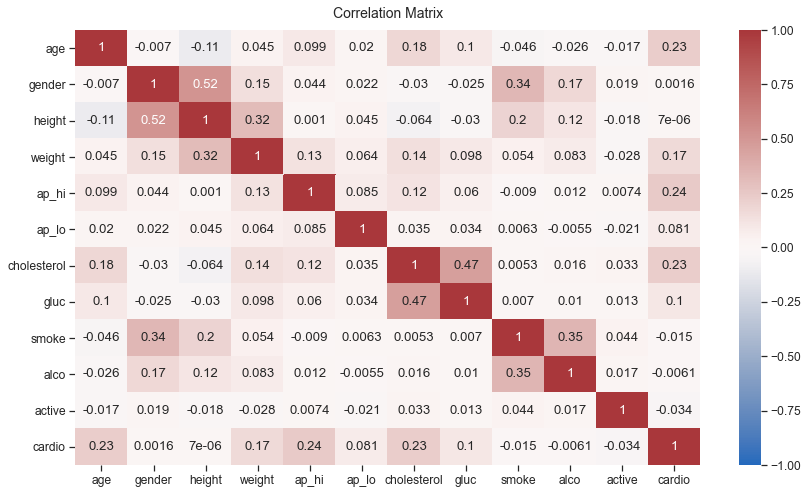

In [4]:
plt.figure(figsize=(14, 8))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag') 
plt.title('Correlation Matrix', fontdict={'fontsize':14}, pad=12)

By looking into the last column, we can see the variables which correlates most to a cardiovascular disease. In this case the biggest influence have the Features age, weight, the upper value of diastolic blood pressure and the cholesterol value. Surprisingly, against any expectations smoking and alcohol does not have any negative impact. 

We plot the Features 'age' and 'weight' to see whether we there is a trend in the data.

<AxesSubplot:xlabel='age', ylabel='weight'>

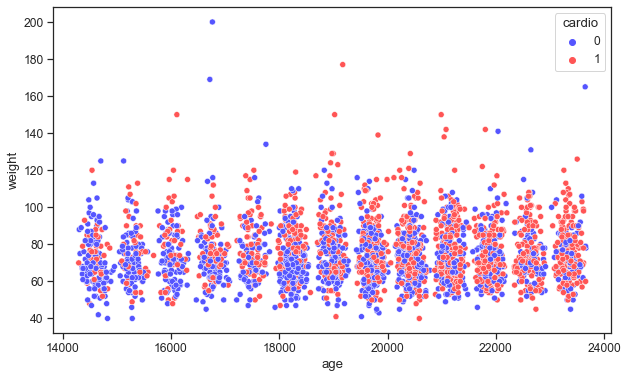

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='weight', data= df, hue='cardio',palette = "seismic")

At first we see that our data is quiet a mess. At first glance there is no chance to linearly seperate it, but we come to this problem later. Nevertheless, you see a trend of Cardiovascular Diseases by an increasing age and weight.

Further, we realize that on the age scale we have to deal with very high numbers which is why age is given in days and not in years. Therefore, we apply Feature Scaling.

### Feature Scaling

Since some features have very high values e.g. 'age' which is given in days, we standardized our data such that all features has a mean of zero and a standard deviation of 1. Therfore, we use the standardization formular:

$\tilde{x_i} = \frac{x_i - \mu}{\sigma}$

In [38]:
import statistics

# data will be saved in extra file so we dont need to run this every time
feature_scale_flag = True

if feature_scale_flag:
    # Min/Max Scaling on I=[0,1]: x_scaled = (x - min(x)) / (max(x) - min(x))
    #df['age_scaled'] = ((df['age'])-min(df['age']))/(max(df['age'])-min(df['age']))
    #df['height_scaled'] = ((df['height'])-min(df['height']))/(max(df['height'])-min(df['height']))
    #df['weight_scaled'] = ((df['weight'])-min(df['weight']))/(max(df['weight'])-min(df['weight']))
    # Standardization: x_standardized = (x - µ) / sigma
    df['age_standardized'] = (df['age']-statistics.mean(df['age'])) / statistics.stdev(df['age'])
    df['height_standardized'] = (df['height']-statistics.mean(df['height'])) / statistics.stdev(df['height'])
    df['weight_standardized'] = (df['weight']-statistics.mean(df['weight'])) / statistics.stdev(df['weight'])

    #df['bmi'] = (df['weight'] / ((df['height'] / 100) ** 2)).round(decimals=2)
    #df['bmi_high'] = (df['bmi'] >= 30).astype(int)

    df['cardio'] = df['cardio'].apply(lambda t: 1 if t==1 else -1).values

    # eliminate corrupted Data
    # TODO: something is wrong here, as its write arrays instead of values, if fixed, its even fast enough to run it without extra save files
    df['ap_lo_fixed'] = [x if 50 < x < 150 else -1 for x in df['ap_lo']]
    df['ap_hi_fixed'] = [x if 100 < x < 190 else -1 for x in df['ap_hi']]
    
    print(df.head())
    # df.to_csv('../resources/feature_scaled_data3.csv', index=True)

      age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                          
0   18393       2     168    62.0    110     80            1     1      0   
1   20228       1     156    85.0    140     90            3     1      0   
2   18857       1     165    64.0    130     70            3     1      0   
3   17623       2     169    82.0    150    100            1     1      0   
4   17474       1     156    56.0    100     60            1     1      0   

    alco  active  cardio  age_scaled  height_scaled  weight_scaled  \
id                                                                   
0      0       1      -1    0.437420       0.754098        0.13750   
1      0       1       1    0.633383       0.655738        0.28125   
2      0       0       1    0.486971       0.729508        0.15000   
3      0       1       1    0.355190       0.762295        0.26250   
4      0       0      -1    0.339278    

We plot our data again to see if our Feature Scaling was succesfull.

<AxesSubplot:xlabel='age_standardized', ylabel='weight_standardized'>

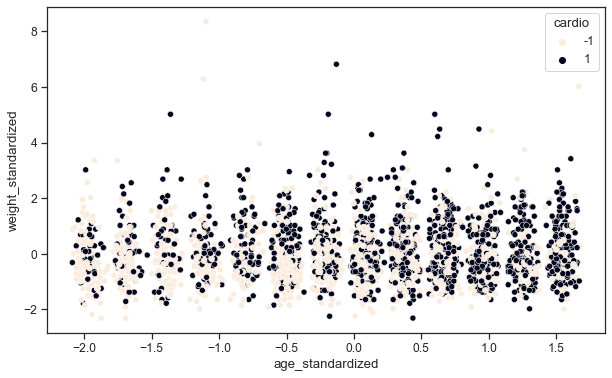

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age_standardized', y='weight_standardized', data= df, hue='cardio', palette = "rocket_r")

### Quick Data Inquiry Result
    > The data is a mess and at the first look not linear separable. So a simple linear classification is not possible.
    > A linear regression does not make sense with the result being a binary "class".

### Kernel / Feature function theory

Proceed by using introducing another dimension to make the data linear separable. This is done by using a feature function or kernel.

linar: $h(x) = w^T \cdot x$ or nonlinar: $h(x) = w^T \cdot \Phi(x)$

Feature Function $\Phi(x)$  based on Age = $A$ and Weight = $W$

$x = [A, W] ∈ R^2$

$ \Phi(x_2) = [1, A, W, A^2, W^2, AW] ∈ R^6$ - optional with ($\sqrt{2}$ for ease of calculation)


 With
 $ K(x, z) = \Phi(x)^T\Phi(z) = (x^T\cdotz+1)^d$ with degree $d = 2$ for a two-dimensional input $x ∈ R^2$.

 $h(x) = w^T \cdot \Phi(x_i)= w^T \cdot K(x,z) = w^T \cdot (x^T\ cdot z+1)^d $

$ min J(w) = \frac{1}{m} \sum_{i=1}^{m} l(h(x_i), y_i) + \Omega(w)$

Kernel can be used not just on age and weight but on all other features.

## Implement functions

### squared exponential kernel $k(x,z)$
$k(x,z) = exp(− x^Tx−2x^Tz+z^Tz/ 2σ^2) = exp(sqdist(x,z)/2σ^2)$

### hypothesis function $h(x)$
$h_\alpha(x) = \alpha K = \sum_{j=1}^{m} \alpha_j k(x_j,x)$

### loss function $l(h(x),y)$

logistic loss:
$l_{logistic}(h_\alpha(x), y) = log(1 + e^{−y·h(x)})= log(1 + exp(−y · h_\alpha(x)))$

### $l_2$ regularizer

$r = \lambda l_2 = \lambda\alpha^{\intercal}K\alpha$


### objective function J

  kernlized logistic regression

reuslting in a regularized kernlized logistic:
$
J(\alpha) = \frac{1}{m}\sum_{i=1}^m  \log \big(1 + \exp\big(-y_i \cdot \sum_{j=1}^{m} \alpha_j k(x_j,x_i)\big) \big) + \lambda \alpha^{\intercal}K\alpha
$

In [39]:
def sqdist(X, Z):
    p1 = np.sum(X**2, axis=1)[:, np.newaxis]
    p2 = np.sum(Z**2, axis=1)
    p3 = -2 * np.dot(X, Z.T)
    return p1+p2+p3

def sq_exp(X, Z, sigma):
    return np.exp(-sqdist(X, Z)/(2*sigma**2) )


def J(α, X, y, sigma, lam):
    K = sq_exp(X, X, sigma)
    m = X.shape[0]
    total_loss = 0
    regularization = lam * np.dot(np.dot(np.transpose(α), K), α)

    for i in range(m):
        prediction = 0
        for j in range(m):
            prediction += α[j]*K[i][j]
        logistic_loss = np.log(1 + np.exp(-y[i] * prediction))
        total_loss += logistic_loss

    mean_loss = total_loss / m  + regularization
    return mean_loss

Implement the gradient of the regularized kernlized logistic regression objective.

In [40]:
def dJ(α, X, y, sigma, lam):
    K = sq_exp(X, X, sigma)
    m = X.shape[0]
    gradient = 0
    regularization = 2*lam * np.dot( K, α)

    for i in range(m):
        prediction = 0
        for j in range(m):
            prediction += α[j]*K[i][j]

        numerator = -y[i] * K[i]
        denominator = 1 + np.exp(y[i] * prediction)
        gradient += numerator / denominator

    mean_gradient = gradient / m + regularization
    return mean_gradient


## Train model

In [41]:
from scipy.optimize import minimize

def kernel_lr(X, y, sigma, lam):
    # implementation of kernel ridge regression using the scipy optimizer gradient descent
    α = np.zeros(X.shape[0],)
    α = minimize(J, α, args=(X, y, sigma, lam), jac=dJ, method='CG').x
    h = lambda Z: np.dot(α, sq_exp(X, Z, sigma))
    return h

## Split data in Train / Validation / Test

We'll first split our data into a Train set (70%) and Test set (30%).  
The training set will be further processed using 10-fold-cross-validation.

In [42]:
def train_test_split(data, train_proportion=0.7, shuffle=False):
    if shuffle:
        indices = np.random.permutation(data.shape[0])
    else:
        indices = np.arange(data.shape[0])

    split_index = int(train_proportion * data.shape[0])
    training_idx = indices[:split_index]
    test_idx = indices[split_index:]

    return data[training_idx, :], data[test_idx, :]


def cross_val(data, k=10):
    assert k >= 2
    datasets = []

    if data.shape[0] % k != 0:
        print("warning: this dataset contains {} entries and cannot be equally divided into {} chunks for cross-validation.".format(data.shape[0], k))
        print("Prutruding rows will be dropped.")
        data = data[ : (data.shape[0] // k) * k]

    for i in range(k):
        data_chunks = np.split(data, k)

        val_data = data_chunks.pop(i)
        train_data = np.concatenate(data_chunks)
        datasets.append((train_data, val_data))

    return datasets

def get_labels_and_features(dataset:np.ndarray)->Tuple[np.ndarray, np.ndarray]:
    """Return labels and features from a given dataset.
    :return: labels, features
    """
    # [0] age - [10] active
    # [11] cardio
    # [12] scaled age - [22]...
    raw_features, labels, features = np.hsplit(dataset, [11,12])
    return labels.flatten(), features


In [43]:
cardio_data = df.to_numpy()
train_data, test_data = train_test_split(cardio_data, shuffle=False)
datasets = cross_val(train_data, k=2)

# only use a single dataset for now
#train_set, val_set = datasets[0]
#y, X = get_labels_and_features(train_set)

## Evaluate minimized hypothesis function $h$

In [44]:
def score(h, X, y):
    predictions = h(X)
    #print(predictions)

    score = (predictions*y >= 0).astype(int)
    return score.sum()/score.shape[0]

def train_n_score(datasets, sigma, lam):
    train_accuracy = []
    val_accuracy = []
    for train_set, val_set in datasets:
        y_train, X_train = get_labels_and_features(train_set)
        y_val, X_val = get_labels_and_features(val_set)

        h = kernel_lr(X_train, y_train, sigma=sigma, lam=lam)

        train_accuracy.append(score(h, X_train, y_train))
        val_accuracy.append(score(h, X_val, y_val))

    print(f'Average model accuracy for sigma={sigma}, lambda={lam}')
    print(f'train: {sum(train_accuracy)/len(train_accuracy)}')
    print(f'val: {sum(val_accuracy)/len(val_accuracy)}\n')


sigmas=[0.5, 1.]
lambdas=[0.1, 1.]

for sigma in sigmas:
    for lam in lambdas:
        train_n_score(datasets, sigma, lam)


Average model accuracy for sigma=0.5, lambda=0.1
train: 0.8533333333333333
val: 0.6866666666666666

Average model accuracy for sigma=0.5, lambda=1.0
train: 0.8533333333333333
val: 0.6866666666666666

Average model accuracy for sigma=1.0, lambda=0.1
train: 0.7747619047619048
val: 0.7052380952380952

Average model accuracy for sigma=1.0, lambda=1.0
train: 0.7719047619047619
val: 0.7071428571428571



In [46]:
from sklearn import preprocessing

def plot_fit(h=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    s1 = ax.scatter(X[y>=0,0], X[y>=0,1], marker='.', color='gray')
    s2 = ax.scatter(X[y<=0,0], X[y<=0,1], marker='.', color='orange')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    plt.xlabel("Ip")
    plt.ylabel("Vp/Vs")
    plt.legend([s1,s2], ['sand', 'shale'])
    if h:
        grid =150
        xx,yy = np.meshgrid(np.linspace(xlim[0], xlim[1], grid), np.linspace(ylim[0], ylim[1], grid))
        XY = np.array([np.ravel(xx), np.ravel(yy)]).T
        P = h(XY).reshape(grid, grid)
        cn = ax.contour(xx, yy, P, colors='k',levels=10)
        ax.clabel(cn, inline=1, fontsize=10)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

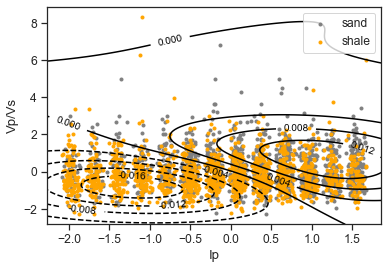

In [48]:
X = df[['age_standardized','weight_standardized']].values
y = df['cardio'].apply(lambda t: 1 if t==1 else -1).values
plot_fit(kernel_lr(X, y, sigma=1, lam=1))